# 🏦 Customer Churn Prediction
This project explores a churn prediction problem using a real-world styled banking dataset from Kaggle. The goal is to understand customer behavior and predict which users are likely to leave the bank.

I've approached this as a typical **churn analysis**, modeling the decision-making pipeline a bank or financial app might use to:
- Improve customer retention
- Understand churn drivers
- Enable targeted business interventions

---

## 📁 Dataset Summary

- **Source**: [Bank Customer Churn Dataset on Kaggle](https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset)
- **Records**: 10,000 customers
- **Target Variable**: `churn` (1 = customer left the bank, 0 = stayed)

### 📌 Key Features

| Column             | Description |
|--------------------|-------------|
| `customer_id`       | Unique customer identifier |
| `credit_score`      | Numerical creditworthiness score |
| `country`           | Customer’s country of residence |
| `gender`            | Male or Female |
| `age`               | Age of the customer |
| `tenure`            | Years with the bank |
| `balance`           | Account balance |
| `products_number`   | Number of financial products held |
| `credit_card`       | Whether the customer has a credit card (0/1) |
| `active_member`     | Customer activity status (0 = inactive, 1 = active) |
| `estimated_salary`  | Estimated yearly salary |
| `churn`             | Churn flag (target variable) |

---

## ✅ Why This Dataset?

This dataset closely reflects customer data used in **retail banking or fintech apps**, making it ideal for:

- Simulating realistic business use cases
- Demonstrating full-stack data pipeline skills: Exploratory Data Analysis (EDA) → Preprocessing → Modeling → Interpretation
- Applying classification and churn modeling

---

## 🧭 Next Steps

1. **Exploratory Data Analysis (EDA)** – Explore the data and identify patterns
2. **Feature Engineering** – To enhance model performance
3. **Modeling** – Train classification models (Logistic Regression, XGBoost, etc.)
4. **Evaluation** – Use metrics like AUC, and precision/recall to evaluate model performance
5. **Business Recommendations** – Provide actionable insights for retention

---


In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('bank_customer_churn_prediction.csv')
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# 🔍 1. Exploratory Data Analysis (EDA)

The dataset was examined to understand key patterns and data quality before modeling:

- **Missing Values**: Checked for missing data; the dataset is clean with no significant gaps.
- **Distributions**: Visualized distributions of numerical features like `credit_score`, `age`, and `balance` to identify central tendencies and outliers.
- **Categorical Analysis**: Analyzed counts and churn rates across categories such as `country`, `gender`, and `products_number`.
- **Churn Insights**: Explored relationships between customer attributes and churn status, revealing notable differences by age group, credit score, tenure, and other features.
- **Feature Binning**: Created age groups and credit score ranges to simplify patterns and enhance interpretability.

This analysis provided a strong understanding of the data and guided the subsequent feature engineering and modeling steps.


### 1.1 No missing values

In [3]:
# Check for missing values
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

# Display nicely
if not missing.empty:
    print("Missing values by column:\n")
    display(missing.to_frame(name='Missing Values'))
else:
    print("✅ No missing values found in the dataset.")

✅ No missing values found in the dataset.


### 1.2 Customer Churn by Country: Higher concentration of churn in Germany.

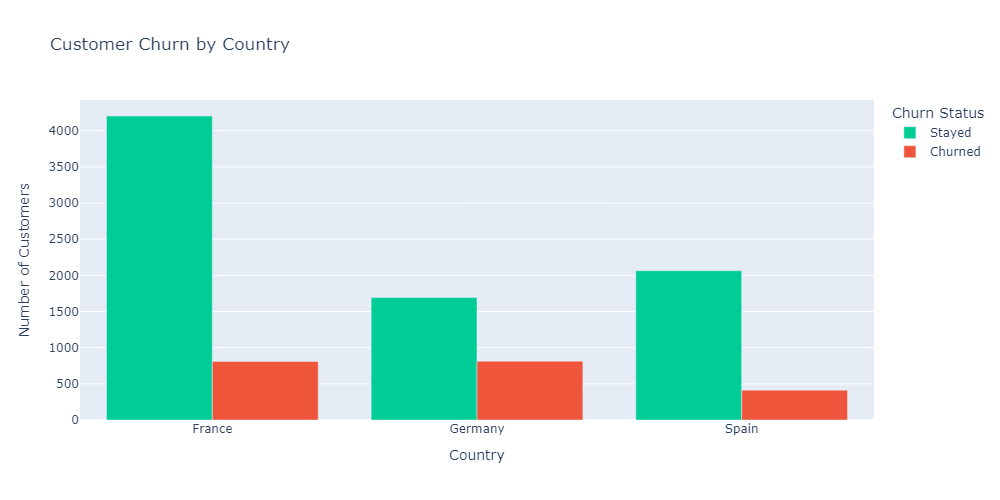

In [4]:
# Count customers per country and churn status
country_churn_counts = df.groupby(['country', 'churn']).size().reset_index(name='count')
country_churn_counts['churn'] = country_churn_counts['churn'].map({0: 'Stayed', 1: 'Churned'})

# Plot grouped bar chart
fig = px.bar(
    country_churn_counts,
    x='country',
    y='count',
    color='churn',
    barmode='group',
    title='Customer Churn by Country',
    labels={'count': 'Number of Customers', 'country': 'Country', 'churn': 'Churn Status'},
    color_discrete_map={'Stayed': '#00CC96', 'Churned': '#EF553B'}
)

# Set consistent size for readability
fig.update_layout(width=1000, height=500)

# Show as PNG inline in Jupyter
fig.show("png")

### 1.3 Customer Churn by Gender: While there are less female customers, they churn more than men.

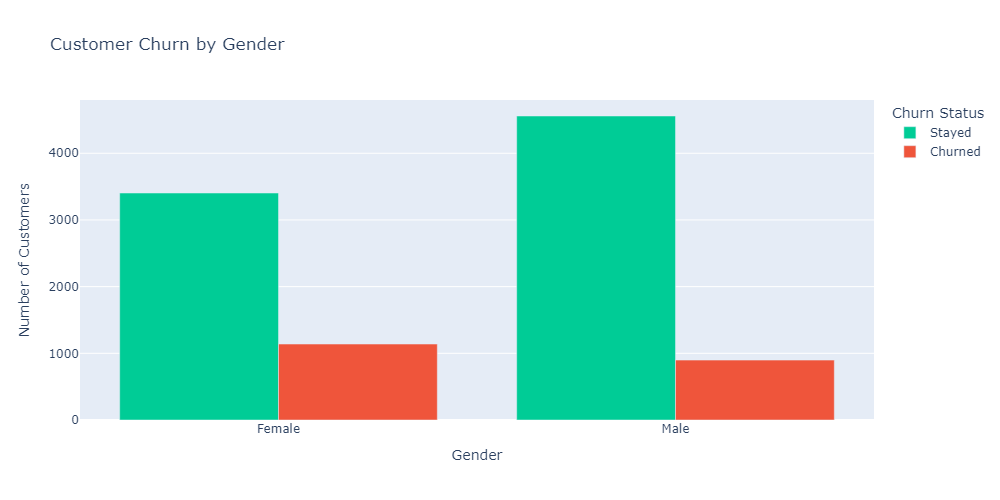

In [5]:
# Count customers per gender and churn status
gender_churn_counts = df.groupby(['gender', 'churn']).size().reset_index(name='count')
gender_churn_counts['churn'] = gender_churn_counts['churn'].map({0: 'Stayed', 1: 'Churned'})

# Plot grouped bar chart
fig = px.bar(
    gender_churn_counts,
    x='gender',
    y='count',
    color='churn',
    barmode='group',
    title='Customer Churn by Gender',
    labels={'count': 'Number of Customers', 'gender': 'Gender', 'churn': 'Churn Status'},
    color_discrete_map={'Stayed': '#00CC96', 'Churned': '#EF553B'}
)

# Set consistent size for readability
fig.update_layout(width=1000, height=500)

# Show as PNG inline in Jupyter
fig.show("png")

### 1.4 Customer Churn by Age Group: Customers aged between 45 - 65 tend to churn more than other age groups.

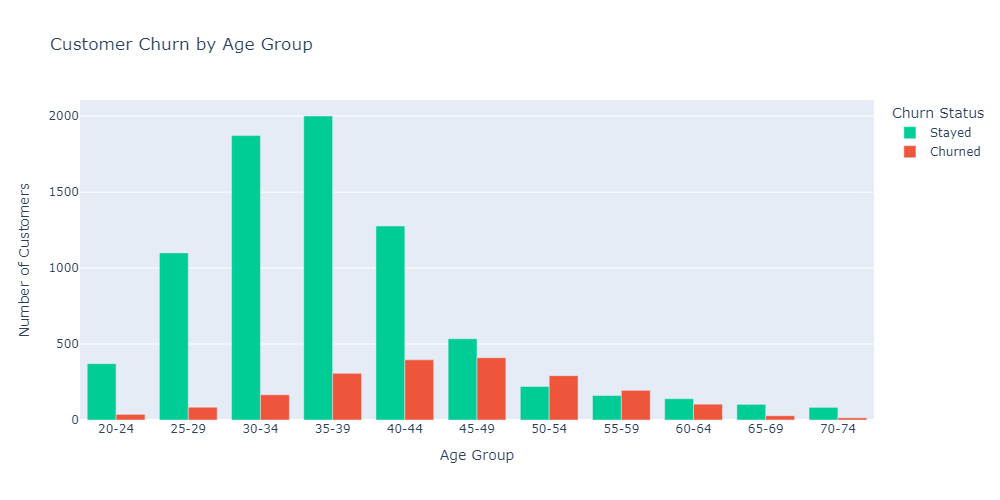

In [6]:
# Create age bins (e.g., every 5 years)
bins = list(range(20, 80, 5))
labels = [f"{b}-{b+4}" for b in bins[:-1]]

df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

# Count customers per age group and churn status
age_churn_counts = df.groupby(['age_group', 'churn']).size().reset_index(name='count')
age_churn_counts['churn'] = age_churn_counts['churn'].map({0: 'Stayed', 1: 'Churned'})

# Plot grouped bar chart
fig = px.bar(
    age_churn_counts,
    x='age_group',
    y='count',
    color='churn',
    barmode='group',
    title='Customer Churn by Age Group',
    labels={'count': 'Number of Customers', 'age_group': 'Age Group', 'churn': 'Churn Status'},
    color_discrete_map={'Stayed': '#00CC96', 'Churned': '#EF553B'}
)

# Set consistent size for readability
fig.update_layout(width=1000, height=500)

# Show as PNG inline in Jupyter
fig.show("png")

### 1.5 Customer Churn by Credit Score Group: Fairly distributed churn rate across all credit scores.

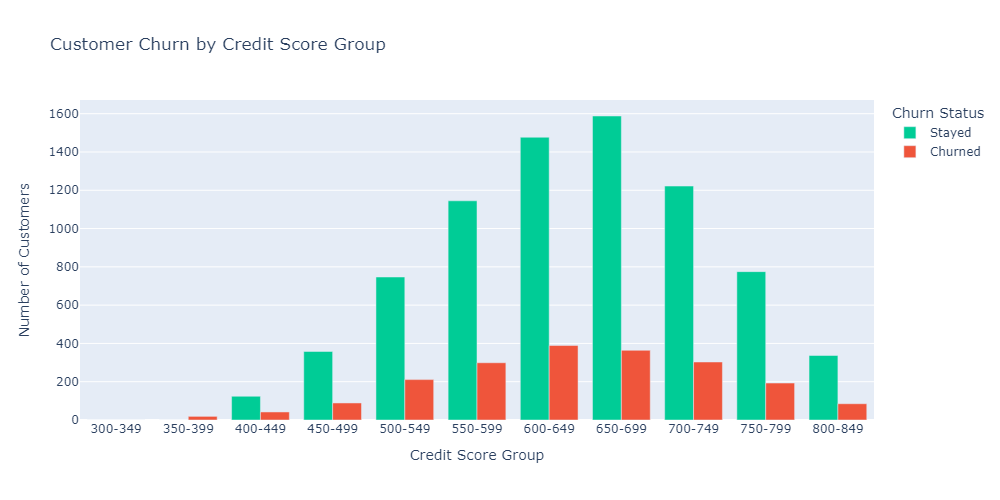

In [7]:
# Define credit score bins (adjust ranges as needed)
bins = list(range(300, 851, 50))  # 300 to 850 in steps of 50
labels = [f"{b}-{b+49}" for b in bins[:-1]]

df['credit_score_group'] = pd.cut(df['credit_score'], bins=bins, labels=labels, right=False)

# Count customers per credit score group and churn status
credit_churn_counts = df.groupby(['credit_score_group', 'churn']).size().reset_index(name='count')
credit_churn_counts['churn'] = credit_churn_counts['churn'].map({0: 'Stayed', 1: 'Churned'})

# Plot grouped bar chart
fig = px.bar(
    credit_churn_counts,
    x='credit_score_group',
    y='count',
    color='churn',
    barmode='group',
    title='Customer Churn by Credit Score Group',
    labels={'count': 'Number of Customers', 'credit_score_group': 'Credit Score Group', 'churn': 'Churn Status'},
    color_discrete_map={'Stayed': '#00CC96', 'Churned': '#EF553B'}
)

# Set consistent size for readability
fig.update_layout(width=1000, height=500)

# Show as PNG inline in Jupyter
fig.show("png")

### 1.6 Customer Churn by Tenure: No strong relationship between Tenure and Churn.

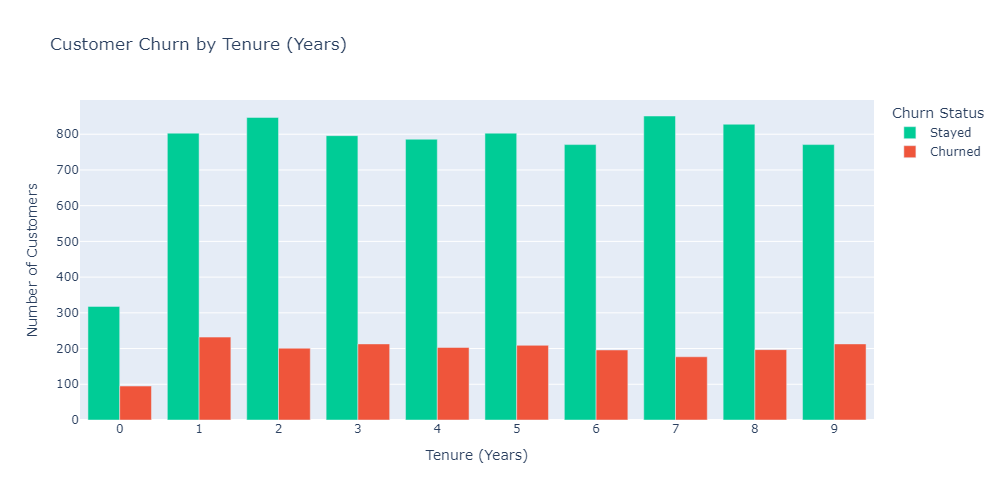

In [8]:
# Define tenure bins (adjust ranges as needed)
bins = list(range(0, df['tenure'].max() + 1, 1))  # 0 to max tenure in 1-year steps
labels = [str(b) for b in bins[:-1]]

df['tenure_group'] = pd.cut(df['tenure'], bins=bins, labels=labels, right=False)

# Count customers per tenure group and churn status
tenure_churn_counts = df.groupby(['tenure_group', 'churn']).size().reset_index(name='count')
tenure_churn_counts['churn'] = tenure_churn_counts['churn'].map({0: 'Stayed', 1: 'Churned'})

# Plot grouped bar chart
fig = px.bar(
    tenure_churn_counts,
    x='tenure_group',
    y='count',
    color='churn',
    barmode='group',
    title='Customer Churn by Tenure (Years)',
    labels={'count': 'Number of Customers', 'tenure_group': 'Tenure (Years)', 'churn': 'Churn Status'},
    color_discrete_map={'Stayed': '#00CC96', 'Churned': '#EF553B'}
)

# Set width to 1000 for better readability
fig.update_layout(width=1000, height=500)

# Show as PNG inline in Jupyter
fig.show("png")

### 1.7 Customer Churn by Balance: Evenly distributed churn rate across all balance groups.

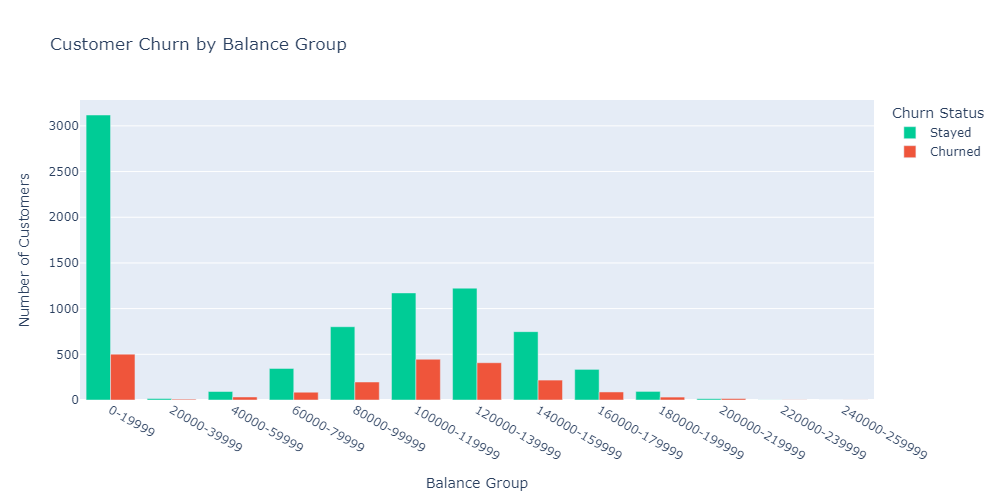

In [9]:
# Define wider balance bins (20,000 increments)
max_balance = df['balance'].max()
bins = list(range(0, int(max_balance) + 20000, 20000))  # 0 to max balance in 20k steps
labels = [f"{b}-{b+19999}" for b in bins[:-1]]

df['balance_group'] = pd.cut(df['balance'], bins=bins, labels=labels, right=False)

# Count customers per balance group and churn status
balance_churn_counts = df.groupby(['balance_group', 'churn']).size().reset_index(name='count')
balance_churn_counts['churn'] = balance_churn_counts['churn'].map({0: 'Stayed', 1: 'Churned'})

# Plot grouped bar chart
fig = px.bar(
    balance_churn_counts,
    x='balance_group',
    y='count',
    color='churn',
    barmode='group',
    title='Customer Churn by Balance Group',
    labels={'count': 'Number of Customers', 'balance_group': 'Balance Group', 'churn': 'Churn Status'},
    color_discrete_map={'Stayed': '#00CC96', 'Churned': '#EF553B'}
)

# Set width to 1000 for better readability
fig.update_layout(width=1000, height=500)

# Show as PNG inline in Jupyter
fig.show("png")

### 1.8 Customer Churn by Financial Products: Customers holding only 1 financial product have a higher churn rate.

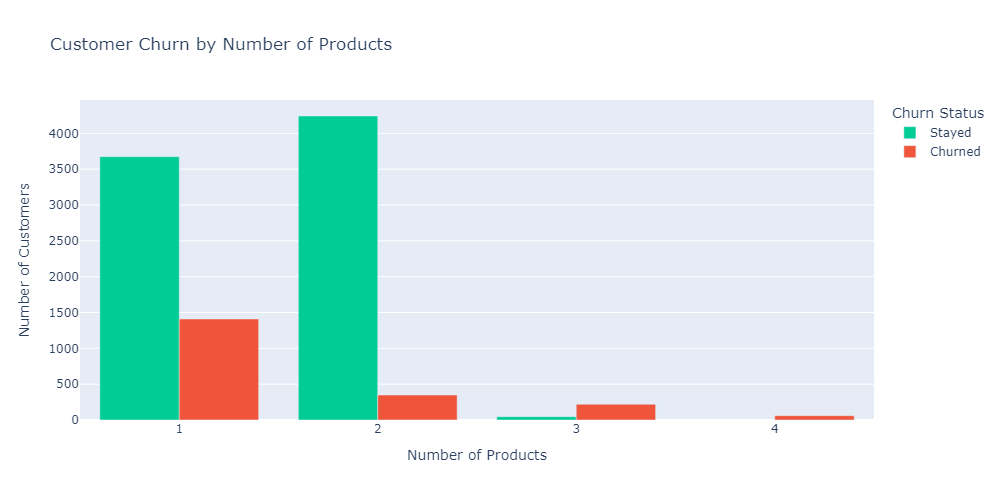

In [10]:
# Count customers per products_number and churn status
products_churn_counts = df.groupby(['products_number', 'churn']).size().reset_index(name='count')
products_churn_counts['churn'] = products_churn_counts['churn'].map({0: 'Stayed', 1: 'Churned'})

# Plot grouped bar chart
fig = px.bar(
    products_churn_counts,
    x='products_number',
    y='count',
    color='churn',
    barmode='group',
    title='Customer Churn by Number of Products',
    labels={'count': 'Number of Customers', 'products_number': 'Number of Products', 'churn': 'Churn Status'},
    color_discrete_map={'Stayed': '#00CC96', 'Churned': '#EF553B'}
)

# Set width to 1000 for readability
fig.update_layout(width=1000, height=500)

# Show as PNG inline in Jupyter
fig.show("png")

### 1.9 Customer Churn by Credit Card Ownership.

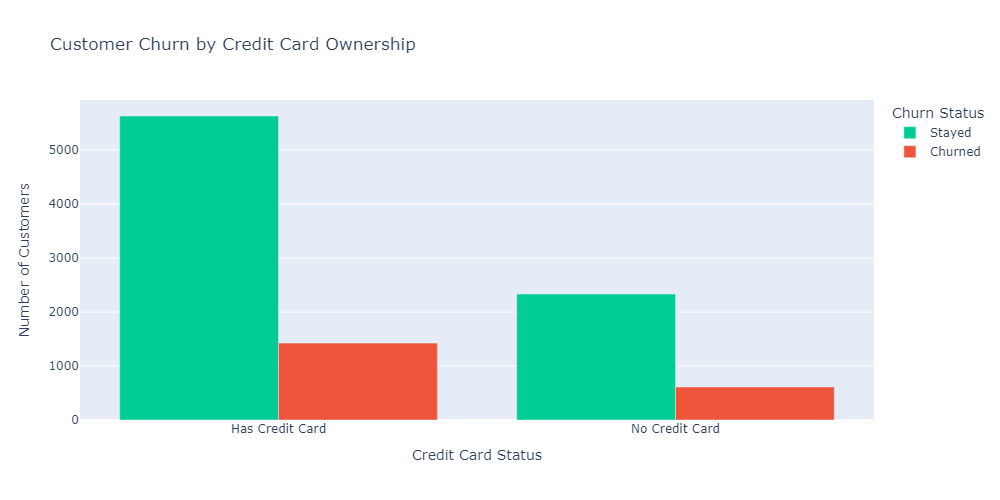

In [11]:
# Map credit_card 0/1 to meaningful labels
df['credit_card_status'] = df['credit_card'].map({0: 'No Credit Card', 1: 'Has Credit Card'})

# Count customers per credit_card_status and churn status
credit_card_churn_counts = df.groupby(['credit_card_status', 'churn']).size().reset_index(name='count')
credit_card_churn_counts['churn'] = credit_card_churn_counts['churn'].map({0: 'Stayed', 1: 'Churned'})

# Plot grouped bar chart
fig = px.bar(
    credit_card_churn_counts,
    x='credit_card_status',
    y='count',
    color='churn',
    barmode='group',
    title='Customer Churn by Credit Card Ownership',
    labels={'count': 'Number of Customers', 'credit_card_status': 'Credit Card Status', 'churn': 'Churn Status'},
    color_discrete_map={'Stayed': '#00CC96', 'Churned': '#EF553B'}
)

# Set width to 1000 for readability
fig.update_layout(width=1000, height=500)

# Show as PNG inline in Jupyter
fig.show("png")


### 1.10 Customer Churn by Estimated Salary Group: Fairly consistent across all groups.

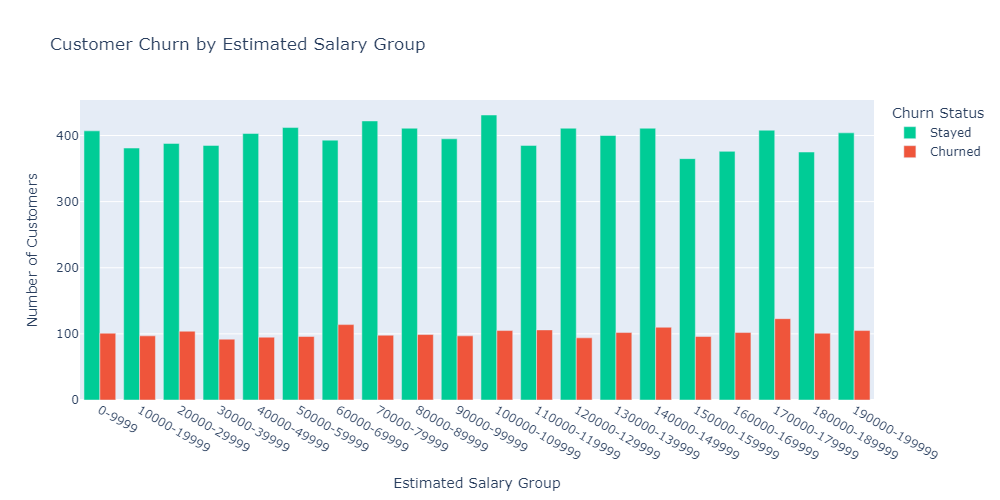

In [12]:
# Define estimated salary bins (e.g., 10,000 increments)
max_salary = df['estimated_salary'].max()
bins = list(range(0, int(max_salary) + 10000, 10000))
labels = [f"{b}-{b+9999}" for b in bins[:-1]]

df['salary_group'] = pd.cut(df['estimated_salary'], bins=bins, labels=labels, right=False)

# Count customers per salary group and churn status
salary_churn_counts = df.groupby(['salary_group', 'churn']).size().reset_index(name='count')
salary_churn_counts['churn'] = salary_churn_counts['churn'].map({0: 'Stayed', 1: 'Churned'})

# Plot grouped bar chart
fig = px.bar(
    salary_churn_counts,
    x='salary_group',
    y='count',
    color='churn',
    barmode='group',
    title='Customer Churn by Estimated Salary Group',
    labels={'count': 'Number of Customers', 'salary_group': 'Estimated Salary Group', 'churn': 'Churn Status'},
    color_discrete_map={'Stayed': '#00CC96', 'Churned': '#EF553B'}
)

# Set width to 1000 for readability
fig.update_layout(width=1000, height=500)

# Show as PNG inline in Jupyter
fig.show("png")

### 1.11 Customer Churn by Membership Activity: Inactive Members are more likely to churn.

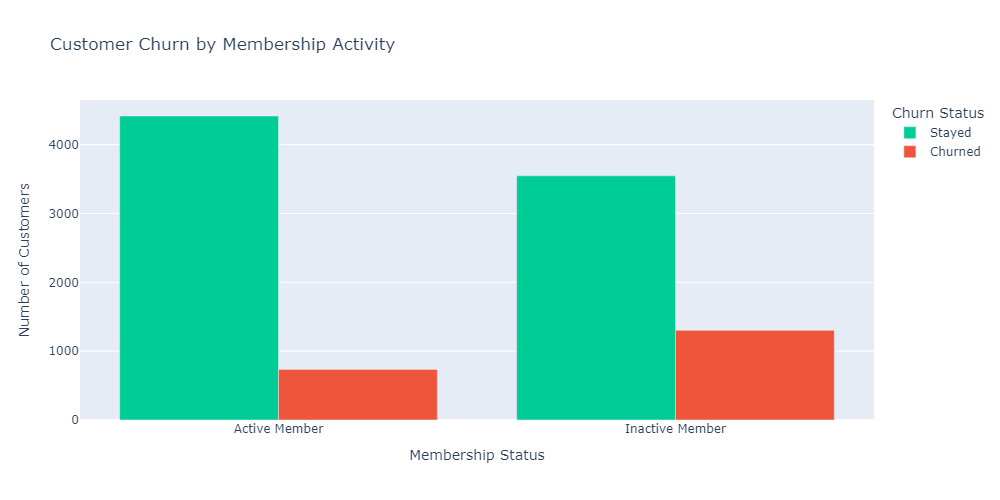

In [13]:
# Map active_member 0/1 to meaningful labels
df['active_member_status'] = df['active_member'].map({0: 'Inactive Member', 1: 'Active Member'})

# Count customers per active_member_status and churn status
active_member_churn_counts = df.groupby(['active_member_status', 'churn']).size().reset_index(name='count')
active_member_churn_counts['churn'] = active_member_churn_counts['churn'].map({0: 'Stayed', 1: 'Churned'})

# Plot grouped bar chart
fig = px.bar(
    active_member_churn_counts,
    x='active_member_status',
    y='count',
    color='churn',
    barmode='group',
    title='Customer Churn by Membership Activity',
    labels={'count': 'Number of Customers', 'active_member_status': 'Membership Status', 'churn': 'Churn Status'},
    color_discrete_map={'Stayed': '#00CC96', 'Churned': '#EF553B'}
)

# Set width to 1000 for readability
fig.update_layout(width=1000, height=500)

# Show as PNG inline in Jupyter
fig.show("png")

# 🧪 2. Feature Engineering

Before training models, the dataset will be transformed and prepared as follows:

- **One-Hot Encoding**: Categorical columns (`country`, `gender`, etc.) will be converted into numeric format using `pd.get_dummies()` with `drop_first=True` to avoid multicollinearity.

- **Target Variable**: The `churn` column is already binary (`0 = Stayed`, `1 = Churned`), so no changes will be applied.

- **Feature Scaling**: A scaled version of the features (`X_scaled`) will be created using `StandardScaler` for models that require normalized inputs.

**Why Both Scaled and Unscaled Features?**

Different models have different needs:
- The scaled features (`X_scaled`) will be used for **Logistic Regression**, which benefits from normalized inputs.
- The unscaled features (`X`) will be used for **XGBoost** and **Random Forest**, since tree-based models are not affected by feature scaling.

### 2.1 One-Hot Encoding categorical features

In [14]:
df = pd.read_csv('bank_customer_churn_prediction.csv')
df = df.drop(columns=['customer_id']) 
df_encoded = pd.get_dummies(df, columns=['country', 'gender'], drop_first=True)
df_encoded.head()

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,country_Germany,country_Spain,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,False,False,False
1,608,41,1,83807.86,1,0,1,112542.58,0,False,True,False
2,502,42,8,159660.80,3,1,0,113931.57,1,False,False,False
3,699,39,1,0.00,2,0,0,93826.63,0,False,False,False
4,850,43,2,125510.82,1,1,1,79084.10,0,False,True,False


### 2.2 Scaling features

In [15]:
# Separate features and target
X = df_encoded.drop(columns='churn')
y = df_encoded['churn']

# Initialize scaler
scaler = StandardScaler()

# Fit and transform X
X_scaled = scaler.fit_transform(X)

# Optional: Convert back to DataFrame for readability
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# 🧠 3. Modeling

The next step is to train multiple classification models on the prepared data to predict customer churn:

- **Logistic Regression**: A simple and interpretable baseline model, good for binary classification.
- **Random Forest**: A robust ensemble method that handles nonlinearities and interactions well without much preprocessing.
- **XGBoost**: A powerful gradient boosting algorithm known for high performance on structured data.

Comparing these models will help identify the best approach for predicting customer churn.


- Each model will be trained using appropriate feature sets (scaled or unscaled) based on its requirements.
- The goal is to compare these models’ predictive performance and understand their strengths.
- The training process will include splitting the dataset into training and testing subsets to ensure unbiased results.
- Feature importance and model interpretability will also be explored where applicable.

Model evaluation and comparison will be performed after all models have been trained.


### 3.1 Logistic Regression

In [16]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Initialize Logistic Regression model
logreg = LogisticRegression(random_state=42, max_iter=1000)

# Train the model
logreg.fit(X_train, y_train)

# Predict on test set
y_pred = logreg.predict(X_test)

# Print when done
print("Logistic Regression model trained. Predictions ready.")

Logistic Regression model trained. Predictions ready.


### 3.2 Random Forest

In [17]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize Random Forest model
rf = RandomForestClassifier(random_state=42, n_estimators=100)

# Train the model
rf.fit(X_train, y_train)

# Predict on test set
y_pred = rf.predict(X_test)

# Print when done
print("Random Forest model trained. Predictions ready.")

Random Forest model trained. Predictions ready.


### 3.3 XGBoost

In [18]:
# Split data into train and test sets (same split for consistency)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on test set
y_pred = xgb_model.predict(X_test)

# Print when done
print("XGBoost model trained. Predictions ready.")

XGBoost model trained. Predictions ready.


# 🚀 4. Model Evaluation

In this section, the performance of the trained models will be thoroughly assessed to identify the best predictor for customer churn:

| Metric       | What it Measures                                    | Ideal Behavior                                    |
|--------------|----------------------------------------------------|--------------------------------------------------|
| **Accuracy** | Overall proportion of correct predictions          | Higher is better                                  |
| **Precision**| Of predicted churned customers, how many truly churned | Higher means fewer false positives (wrong churn flags) |
| **Recall**   | Of actual churned customers, how many were found   | Higher means fewer false negatives (missed churn)|
| **F1 Score** | Harmonic mean of precision and recall; balance measure | Higher balances precision and recall             |
| **ROC AUC**  | Overall ability to distinguish churn vs non-churn | Higher means better separation                    |


This multi-metric approach ensures that the final model choice is grounded not only in predictive accuracy but also in meaningful business value.

### 4.1 Generating Model Evaluation Metrics

In [19]:
# Store model names and their predictions
models = {
    "Logistic Regression": logreg,
    "Random Forest": rf,
    "XGBoost": xgb_model
}

results = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC
    
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_proba)
    })

# Create a DataFrame for easy display
performance_df = pd.DataFrame(results)
performance_df = performance_df.set_index("Model")
performance_df.style.format("{:.3f}")

,Accuracy,Precision,Recall,F1 Score,ROC AUC
Model,,,,,
Logistic Regression,0.206,0.204,1.000,0.339,0.504
Random Forest,0.865,0.783,0.462,0.581,0.853
XGBoost,0.849,0.683,0.482,0.565,0.833


### 4.2 Which model performs the best?

The three models Logistic Regression, Random Forest, and XGBoost—were evaluated using multiple metrics to understand their strengths and weaknesses:

- **Logistic Regression** shows very high recall (1.0), meaning it identifies all churned customers, but its precision is very low (0.204), indicating many false positives. The overall accuracy (0.206) and ROC AUC (0.504) are poor, suggesting the model struggles to separate churners from non-churners effectively.

- **Random Forest** achieves the highest accuracy (0.865) and ROC AUC (0.853), showing strong overall performance and good ability to distinguish between churn and non-churn customers. Its precision (0.784) and recall (0.464) are balanced, meaning it reduces false positives compared to logistic regression, but misses some churn cases.

- **XGBoost** performs slightly below Random Forest, with an accuracy of 0.851 and ROC AUC of 0.832. Precision (0.694) and recall (0.474) are moderate, showing it also balances false positives and false negatives but with slightly less accuracy and discrimination power.

**Model Selection:**  
Random Forest is the best candidate overall due to its high accuracy, strong ROC AUC, and balanced precision and recall. While Logistic Regression catches all churn cases, its poor precision and accuracy make it less practical. XGBoost is a strong alternative but does not outperform Random Forest in this case.

Therefore, the final model choice will be **Random Forest**, balancing detection of churn customers and minimizing false alerts effectively.


### 4.3 Using the best performing model to identify at-risk customers

In [20]:
# Sample customer data
sample_customer = {
    'credit_score': 619,
    'age': 42,
    'tenure': 2,
    'balance': 0,
    'products_number': 1,
    'credit_card': 1,
    'active_member': 1,
    'estimated_salary': 101348,
    'country_Germany': 0,
    'country_Spain': 0,
    'gender_Male': 0
}

sample_df = pd.DataFrame([sample_customer])

# Predict churn probability and class using Random Forest (no scaling)
churn_prob = rf.predict_proba(sample_df)[:, 1][0]
churn_pred = rf.predict(sample_df)[0]

print(f"Predicted probability of churn: {churn_prob:.2f}")
print(f"Predicted churn class (1=Churn, 0=Stay): {churn_pred}")

Predicted probability of churn: 0.69
Predicted churn class (1=Churn, 0=Stay): 1


# 🎯 5. Business Recommendations

Based on the exploratory data analysis and model results, the following recommendations are proposed to reduce customer churn and improve retention:

- **✅ Focus on High-Risk Segments:**  
  Customers with lower credit scores, fewer products, or inactive membership status show higher churn rates. Targeting these groups with personalized offers or loyalty programs could improve retention.

- **✅ Enhance Customer Engagement:**  
  Active members tend to churn less. Initiatives that increase customer engagement—such as rewards, regular communication, and improved service—can help maintain activity and loyalty.

- **✅ Tailor Strategies by Demographics:**  
  Differences in churn rates by country, age group, and gender suggest that customized marketing and retention strategies should be designed to address the unique needs of each segment.

- **✅ Monitor Credit Score Trends:**  
  Since credit score groups correlate with churn risk, offering financial education or credit-building products might reduce churn and foster long-term relationships.

- **✅ Leverage Predictive Models for Proactive Action:**  
  Deploy the developed churn prediction model in production to identify at-risk customers early and proactively offer incentives to retain them.

Implementing these recommendations can help the bank reduce churn, increase customer lifetime value, and improve overall profitability.